#Downloading UC Merced is a 21 class dataset

In [ ]:
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import wget

url = 'https://mymldatasets.s3.eu-de.cloud-object-storage.appdomain.cloud/UCMerced_LandUse.zip'
wget.download(url)

'UCMerced_LandUse.zip'

### Extracting the data from Zip file

In [ ]:
import zipfile
with zipfile.ZipFile('UCMerced_LandUse.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [ ]:
import os
from pathlib import Path

PATH = Path('dataset/Images')

labels = os.listdir(PATH)
labels, len(labels)

(['tenniscourt',
  'airplane',
  'denseresidential',
  'golfcourse',
  'beach',
  'buildings',
  'freeway',
  'mediumresidential',
  'harbor',
  'sparseresidential',
  'storagetanks',
  'parkinglot',
  'chaparral',
  'intersection',
  'forest',
  'mobilehomepark',
  'runway',
  'agricultural',
  'overpass',
  'river',
  'baseballdiamond'],
 21)

### Images in each class

In [ ]:
for label in labels:
    items = os.listdir(PATH/label)
    print(label, ':', len(items))

tenniscourt : 100
airplane : 100
denseresidential : 100
golfcourse : 100
beach : 100
buildings : 100
freeway : 100
mediumresidential : 100
harbor : 100
sparseresidential : 100
storagetanks : 100
parkinglot : 100
chaparral : 100
intersection : 100
forest : 100
mobilehomepark : 100
runway : 100
agricultural : 100
overpass : 100
river : 100
baseballdiamond : 100


In [ ]:
import torch
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.Resize(228),
                                transforms.CenterCrop(227),
                                transforms.ToTensor()])

In [ ]:
dataset = datasets.ImageFolder(root=PATH, transform=transform)
classes = dataset.classes

# Saprating Data into 14 and 7 classes sets

In [ ]:
dataset_1 = [] # First 14 classes
dataset_2 = [] # Last 7 classes

for d in dataset:
    if d[1]<14:
        dataset_1.append(d)
    else:
        dataset_2.append(d)

# Dividing 14 classes set into train (75%) and test (25%)

In [ ]:
from sklearn.model_selection import train_test_split
train_dataset, test_dataset = train_test_split(dataset_1, test_size=0.25, random_state=42)
len(train_dataset), len(test_dataset)

(1050, 350)

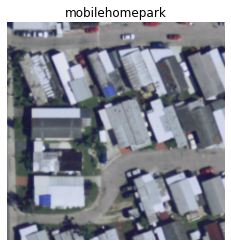

In [ ]:
import matplotlib.pyplot as plt
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=25, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=25, shuffle=True)

images, labels = next(iter(train_dataloader))
plt.imshow(images[0].permute(1,2,0))
plt.axis(False)
plt.title(classes[labels[0]]);

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

# Accuracy Function

In [ ]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

# Train and Test function for Model

In [ ]:
def train_step(model:torch.nn.Module,
               data_loader:torch.utils.data.DataLoader,
               loss_f:torch.nn.Module,
               optimizer_f: torch.optim.Optimizer,
               accuracy):
  model.train()
  train_loss, train_acc = 0, 0
  for batch, (X,y) in enumerate(data_loader):
    # Send data to GPU
    X, y = X.to(DEVICE), y.to(DEVICE)
    # 1. Forward pass
    y_preds = model(X)
    # 2. Calculate loss
    loss = loss_f(y_preds, y)
    train_loss += loss
    # Accuracy calculation
    train_acc += accuracy(y, y_preds.argmax(dim=1))
    # 3. Optimizer zero grad
    optimizer_f.zero_grad()
    # 4. Loss backward
    loss.backward()
    # 5. Optimizer step
    optimizer_f.step()
  # Calculate loss and accuracy per epoch and print out what's happening
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")


def test_step(model:torch.nn.Module,
               data_loader:torch.utils.data.DataLoader,
               loss_f:torch.nn.Module,
               accuracy):
  loss, acc = 0, 0

  with torch.inference_mode():
    model.eval()
    for X,y in data_loader:
      X, y = X.to(DEVICE), y.to(DEVICE)
      # 1. Forward pass
      y_preds = model(X)
      # 2. Calculate loss (accumatively)
      loss += loss_f(y_preds, y) ## accumulatively add up the loss per epoch
      # 3. Calculate accuracy (preds need to be same as y_true)
      acc += accuracy(y, y_preds.argmax(dim=1))
    # Calculations on test metrics need to happen inside torch.inference_mode()
    # Divide total test loss by length of test dataloader (per batch)
    loss /= len(data_loader)
    # Divide total accuracy by length of test dataloader (per batch)
    acc /= len(data_loader)
    ## Print whats happening
    print(f"Test loss: {loss:.5f} | Test accuracy: {acc:.2f}%\n")

# Using ResNet34 Model

In [ ]:
resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34').to(DEVICE)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [ ]:
class LandUse(torch.nn.Module):
  def __init__(self, pre_model:torch.nn.Module):
    super().__init__()
    self.model_A = pre_model
    self.out = torch.nn.Sequential(torch.nn.ReLU(),
        torch.nn.Linear(in_features=1000, out_features=14)
        )
  def forward(self, x:torch.Tensor):
    return self.out(self.model_A(x))

In [ ]:
model = LandUse(resnet).to(DEVICE)

# setting up Loss function and Optimizer

In [ ]:
# Setup loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), 
                             lr=0.1)

# Training and Testing the model

In [ ]:
import time
epochs = 100
start_time = time.time()
for epoch in range(epochs):
  print(f"Epoch: {epoch}\n---------")
  train_step(data_loader=train_dataloader, 
      model=model, 
      loss_f=loss_fn,
      optimizer_f=optimizer,
      accuracy=accuracy_fn
  )

  test_step(data_loader=test_dataloader,
      model=model,
      loss_f=loss_fn,
      accuracy=accuracy_fn
  )

end_time = time.time()
print(f"Time Taken: {end_time-start_time} sec.")

Epoch: 0
---------
Train loss: 2.29235 | Train accuracy: 21.90%
Test loss: 2.18485 | Test accuracy: 26.00%

Epoch: 1
---------
Train loss: 1.87699 | Train accuracy: 35.71%
Test loss: 2.30825 | Test accuracy: 25.71%

Epoch: 2
---------
Train loss: 1.62835 | Train accuracy: 43.90%
Test loss: 2.57431 | Test accuracy: 31.71%

Epoch: 3
---------
Train loss: 1.43832 | Train accuracy: 50.00%
Test loss: 2.17672 | Test accuracy: 34.57%

Epoch: 4
---------
Train loss: 1.24805 | Train accuracy: 56.48%
Test loss: 3.92040 | Test accuracy: 23.14%

Epoch: 5
---------
Train loss: 1.14110 | Train accuracy: 59.33%
Test loss: 2.92585 | Test accuracy: 43.71%

Epoch: 6
---------
Train loss: 1.05128 | Train accuracy: 63.24%
Test loss: 1.84975 | Test accuracy: 46.57%

Epoch: 7
---------
Train loss: 0.89682 | Train accuracy: 69.05%
Test loss: 1.09723 | Test accuracy: 58.57%

Epoch: 8
---------
Train loss: 0.88668 | Train accuracy: 68.86%
Test loss: 1.22922 | Test accuracy: 59.43%

Epoch: 9
---------
Train los

# Evalution Function for max-Softmax

In [ ]:
def eval_step(model:torch.nn.Module,
               data_loader:torch.utils.data.DataLoader):
  max_soft_max = torch.tensor([]).to(DEVICE)

  with torch.inference_mode():
    model.eval()
    for X,y in data_loader:
      X, y = X.to(DEVICE), y.to(DEVICE)
      # 1. Forward pass
      y_logits = model(X)
      soft_max = torch.nn.Softmax(dim=1)
      max_soft_max = torch.cat((max_soft_max, torch.max(soft_max(y_logits), dim=1).values), dim=-1)
  return max_soft_max

In [ ]:
test_max_softmax = eval_step(model, test_dataloader)
test_max_softmax, test_max_softmax.shape

(tensor([0.5351, 0.9988, 1.0000, 1.0000, 0.7187, 0.9912, 0.9526, 0.7069, 0.9993,
         0.9999, 1.0000, 0.9650, 1.0000, 1.0000, 0.6534, 0.9378, 1.0000, 0.9955,
         0.9993, 1.0000, 0.6405, 1.0000, 1.0000, 0.9934, 0.9986, 0.9853, 1.0000,
         1.0000, 0.9999, 0.9998, 1.0000, 0.9999, 1.0000, 1.0000, 0.5098, 0.9995,
         0.9859, 1.0000, 0.9996, 1.0000, 0.9999, 1.0000, 1.0000, 0.9902, 0.9951,
         0.5934, 0.7102, 1.0000, 0.9764, 0.9997, 0.9975, 1.0000, 1.0000, 0.6422,
         1.0000, 0.9614, 0.9585, 0.7324, 1.0000, 0.9999, 0.7903, 0.9985, 1.0000,
         0.9914, 1.0000, 1.0000, 1.0000, 1.0000, 0.7248, 0.9998, 1.0000, 1.0000,
         0.9942, 0.9988, 1.0000, 1.0000, 0.9696, 1.0000, 0.9524, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 0.9475, 0.9980, 0.9961, 0.8998, 0.9970, 1.0000,
         0.9992, 1.0000, 0.9999, 0.9999, 1.0000, 0.9998, 0.9826, 1.0000, 1.0000,
         0.8129, 1.0000, 0.9999, 1.0000, 1.0000, 1.0000, 0.9969, 1.0000, 1.0000,
         0.9999, 1.0000, 0.9

In [ ]:
torch.mean(test_max_softmax)

tensor(0.9540, device='cuda:0')

In [ ]:
new_dataloader = torch.utils.data.DataLoader(dataset_2, batch_size=25, shuffle=False)

In [ ]:
new_max_softmax = eval_step(model, new_dataloader)
new_max_softmax, new_max_softmax.shape

(tensor([0.7762, 0.8518, 0.9991, 0.9999, 0.9986, 0.9998, 0.9495, 0.9981, 0.9521,
         0.7075, 0.9919, 0.9901, 0.9992, 0.7751, 0.8948, 1.0000, 0.9996, 0.8435,
         0.9996, 0.9882, 0.8986, 0.8560, 0.9997, 0.5834, 0.9825, 0.6505, 0.5070,
         0.3840, 0.7990, 0.9997, 0.9999, 0.9521, 0.9980, 0.9997, 0.9832, 0.7268,
         0.9804, 1.0000, 0.9626, 0.9170, 0.8690, 0.9984, 0.9738, 0.9989, 0.9999,
         0.9800, 0.9993, 0.9964, 0.9766, 0.5297, 0.8037, 0.6829, 0.8040, 0.8981,
         0.3477, 0.9712, 0.9922, 0.9973, 0.9990, 0.5677, 0.7994, 0.5742, 0.9939,
         0.9979, 0.9632, 0.9374, 0.9882, 0.9357, 0.9341, 1.0000, 0.5682, 0.9358,
         0.9145, 0.9975, 1.0000, 0.7070, 0.9990, 0.9995, 0.9971, 0.9323, 0.9998,
         0.9719, 0.6310, 0.6777, 1.0000, 0.8832, 0.9957, 0.9524, 0.9974, 0.5608,
         0.9998, 0.7370, 0.4847, 0.9640, 0.9515, 0.6355, 0.9995, 0.9966, 0.9952,
         0.7047, 0.5028, 0.8883, 0.3638, 0.9341, 0.5193, 0.9818, 0.5367, 0.9862,
         0.8619, 0.9725, 0.7

In [ ]:
torch.mean(new_max_softmax)

tensor(0.8376, device='cuda:0')